## Imports

In [7]:
import pandas as pd
import numpy as np
import sqlite3
import os
import joblib

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ML evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Define database and transformers paths
db_path = "../database/ELECTIONS.db"
db_dir = os.path.dirname(db_path)
preprocessor_path = os.path.join(db_dir, 'preprocessor_X.joblib')
label_encoder_path = os.path.join(db_dir, 'label_encoder_y.joblib')

# Connect to the database
conn = sqlite3.connect(db_path)

# Load the processed data from the database
train_df = pd.read_sql('SELECT * FROM PROCESSED_TRAIN_DATA', conn)
test_df = pd.read_sql('SELECT * FROM PROCESSED_TEST_DATA', conn)

print("Loaded data from database:")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Load the transformers
preprocessor_X = joblib.load(preprocessor_path)
label_encoder_y = joblib.load(label_encoder_path)

print("\nSuccessfully loaded preprocessor and label encoder.")

Loaded data from database:
Training data shape: (652, 99)
Testing data shape: (94, 99)

Successfully loaded preprocessor and label encoder.


In [9]:
# The target column is named 'WINNER_encoded'
target_column = 'WINNER_encoded'

X_train = train_df.drop(target_column, axis=1)
y_train = train_df[target_column]

X_test = test_df.drop(target_column, axis=1)
y_test = test_df[target_column]

print("Data separated into X and y sets:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Data separated into X and y sets:
X_train shape: (652, 98)
y_train shape: (652,)
X_test shape: (94, 98)
y_test shape: (94,)


In [10]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder_y.classes_, output_dict=True)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'y_pred': y_pred
    }
    
    print(f'--- {name} ---\n')
    print(f'Accuracy: {accuracy:.4f}\n')
    # Print text report
    print(classification_report(y_test, y_pred, target_names=label_encoder_y.classes_))
    print("---------------------\n\n")

--- Logistic Regression ---

Accuracy: 0.2979

              precision    recall  f1-score   support

      CENTRE       0.24      0.89      0.38        18
      DROITE       0.20      0.43      0.27         7
    E.DROITE       0.64      0.16      0.25        45
      GAUCHE       1.00      0.08      0.15        24

    accuracy                           0.30        94
   macro avg       0.52      0.39      0.26        94
weighted avg       0.62      0.30      0.25        94

---------------------


--- Random Forest ---

Accuracy: 0.4787

              precision    recall  f1-score   support

      CENTRE       0.30      0.89      0.45        18
      DROITE       0.57      0.57      0.57         7
    E.DROITE       0.82      0.31      0.45        45
      GAUCHE       0.65      0.46      0.54        24

    accuracy                           0.48        94
   macro avg       0.59      0.56      0.50        94
weighted avg       0.66      0.48      0.48        94

------------------

/Users/hich/Desktop/Bureau - MacbookAir HICHAM/PRO/GIT/epsi-mspr-1/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:17:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost ---

Accuracy: 0.4255

              precision    recall  f1-score   support

      CENTRE       0.29      0.89      0.44        18
      DROITE       0.38      0.43      0.40         7
    E.DROITE       0.79      0.24      0.37        45
      GAUCHE       0.59      0.42      0.49        24

    accuracy                           0.43        94
   macro avg       0.51      0.49      0.42        94
weighted avg       0.61      0.43      0.42        94

---------------------




/var/folders/sp/w9p124nd6jb9srzf94f0v2q80000gn/T/ipykernel_14491/4112979148.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='viridis')


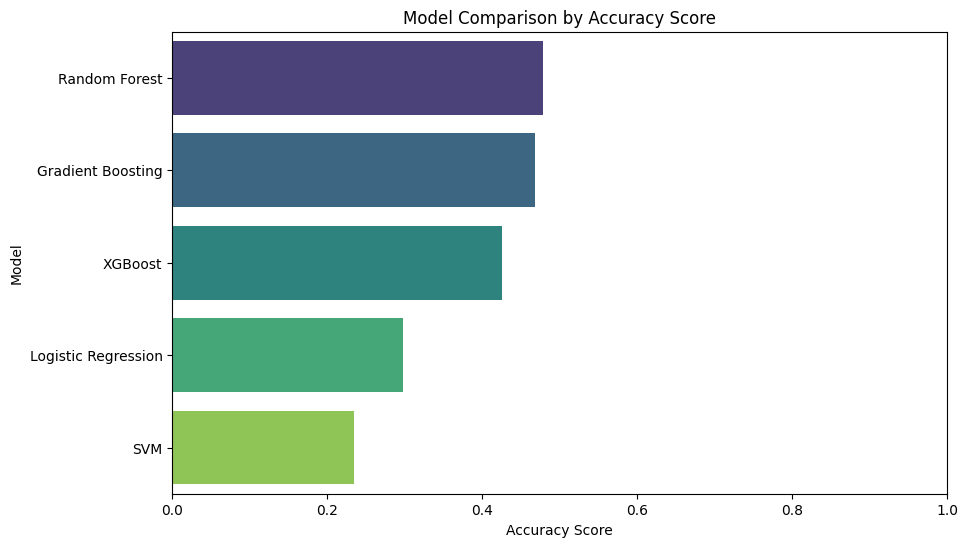

Model Performance Summary:
                 Model  Accuracy
0        Random Forest  0.478723
1    Gradient Boosting  0.468085
2              XGBoost  0.425532
3  Logistic Regression  0.297872
4                  SVM  0.234043


In [11]:
accuracy_df = pd.DataFrame([
    {'Model': name, 'Accuracy': res['accuracy']}
    for name, res in results.items()
])

accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='viridis')
plt.title('Model Comparison by Accuracy Score')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.xlim(0, 1.0)
plt.show()

print("Model Performance Summary:")
print(accuracy_df)

## Export model

Now we know that the most perfomant model is Logistic Regression, we will export it so we could use it simply

In [12]:
selected_model_name = 'Logistic Regression'
print(f"Selected model to save: '{selected_model_name}'")

# Get the actual model object from our results dictionary
# The 'results' dictionary was created when we trained the models.
best_model_to_save = results[selected_model_name]['model']

# Creating a dedicated directory for saving models if it doesn't already exist
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Define the file path for the saved model
model_path = os.path.join(model_dir, 'logistic_regression_predictor.joblib')

# Save the Logistic Regression model object to a file using joblib
joblib.dump(best_model_to_save, model_path)

print(f"\nModel saved successfully to: {model_path}")
print("\nWe can now load this file in a new script to make future predictions.")

Selected model to save: 'Logistic Regression'

Model saved successfully to: ../models/logistic_regression_predictor.joblib

We can now load this file in a new script to make future predictions.
